# From Prediction to Action: Optimizing Resource Allocation with Dynamic Programming

This notebook presents a comprehensive exploration of dynamic programming (DP) techniques applied to a real-world resource allocation problem inspired by the Abalone harvesting scenario. The goal is to model a diver's sequential decision-making process using a Markov Decision Process (MDP) to maximize profit while managing time and risk.

## Overview

- **Resource Allocation Challenge:**
  Understand the complexity of optimally allocating limited resources (time, in this case) when facing uncertainty in outcomes.

- **Dynamic Programming Approach:**
  Learn how DP decomposes a large decision-making problem into smaller, manageable subproblems, solves them efficiently, and combines their solutions to find the globally optimal strategy.

- **MDP Formulation:**
  Model the diver’s decisions with an MDP by defining:
  - **States:** Representing the remaining time and the current classification status of an Abalone.
  - **Actions:** Choices available to the diver (Ignore, Collect, Analyze).
  - **Transition Probabilities:** Capturing the uncertainty in outcomes (e.g., encountering a male, female, or infant).
  - **Rewards:** Quantifying profits or penalties based on actions and outcomes.
  - **Discount Factor:** Balancing immediate versus future rewards.

- **Implementation and Visualization:**
  The notebook includes a full Python implementation of the `DiverMDP` class and the Value Iteration algorithm to compute the optimal policy. Visualizations illustrate the optimal value function and policy across different states.

- **Future Directions:**
  Ideas for further enhancements are discussed, including:
  - Policy evaluation and policy iteration techniques.
  - Enriching the state space (e.g., incorporating diver energy, visibility, weather conditions, and UV sensor data).
  - Modeling stochastic rewards to reflect real-world market fluctuations.
  - Enhanced visualizations and sensitivity analysis.
  - Generalizing the framework to other resource allocation problems.

This notebook serves as both an educational tool for understanding dynamic programming and a practical framework for optimizing sequential decisions in challenging, real-world scenarios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class EnhancedDiverMDP:
    def __init__(self, time_steps=5, max_inventory=3,
                 prob_male=0.4, prob_female=0.4, prob_infant=0.2,
                 profit_male=1.0, cost_female=-1.0, cost_infant=-1.5,
                 time_cost_analyze=2, time_cost_ignore=1, discount_factor=0.95,
                 holding_cost=0.1, overcapacity_penalty=-5.0, spoilage_penalty=-2.0,
                 cost_analyse=1):
        """
        Initializes the enhanced MDP with inventory management.

        Args:
            time_steps (int): Number of time steps (e.g., dive duration).
            max_inventory (int): Maximum storage capacity onboard.
            prob_male, prob_female, prob_infant (float): Probabilities of encountering each type.
            profit_male (float): Profit from a male abalone.
            cost_female, cost_infant (float): Penalties for collecting female or infant.
            time_cost_analyze, time_cost_ignore (int): Time cost for actions.
            discount_factor (float): Discount factor for future rewards.
            holding_cost (float): Cost per abalone in storage per time step.
            overcapacity_penalty (float): Penalty for trying to collect when inventory is full.
            spoilage_penalty (float): Penalty at terminal states for items that spoil.
        """
        self.time_steps = time_steps
        self.max_inventory = max_inventory
        self.prob_male = prob_male
        self.prob_female = prob_female
        self.prob_infant = prob_infant
        self.profit_male = profit_male
        self.cost_female = cost_female
        self.cost_infant = cost_infant
        self.time_cost_analyze = time_cost_analyze
        self.time_cost_ignore = time_cost_ignore
        self.discount_factor = discount_factor
        self.holding_cost = holding_cost
        self.overcapacity_penalty = overcapacity_penalty
        self.spoilage_penalty = spoilage_penalty
        self.cost_analyse = cost_analyse

        self.num_actions = 3  # 0: Ignore, 1: Collect, 2: Analyze
        # abalone_status: 0: Not Classified, 1: Male, 2: Female, 3: Infant
        self.num_abalone_status = 4

        # Extended state space: (time_remaining, abalone_status, inventory_level)
        self.states = [(t, a, i) for t in range(self.time_steps + 1)
                                  for a in range(self.num_abalone_status)
                                  for i in range(self.max_inventory + 1)]
        self.state_index = {s: i for i, s in enumerate(self.states)}
        num_states = len(self.states)

        # Initialize Transition and Reward matrices
        self.transition_matrix = np.zeros((num_states, self.num_actions, num_states))
        self.reward_matrix = np.zeros((num_states, self.num_actions, num_states))

        self._build_transition_reward_matrices()

    def _build_transition_reward_matrices(self):
        """
        Build transition and reward matrices for the extended state space.
        """
        for state in self.states:
            t, a_status, inv = state
            s_idx = self.state_index[state]
            # Terminal state: if time is 0, stay in the same state and incur spoilage penalty.
            if t == 0:
                self.transition_matrix[s_idx, :, s_idx] = 1.0
                self.reward_matrix[s_idx, :, :] = self.spoilage_penalty * inv
                continue

            for action in range(self.num_actions):
                # Determine time cost
                if action == 2:  # Analyze takes more time.
                    dt = self.time_cost_analyze
                else:
                    dt = self.time_cost_ignore
                next_t = max(0, t - dt)

                # Apply holding cost for current inventory
                holding = - self.holding_cost * inv

                if action == 1:  # Collect
                    if inv < self.max_inventory:
                        # If abalone is not classified, outcomes occur probabilistically.
                        if a_status == 0:
                            outcomes = [("male", self.prob_male), ("female", self.prob_female), ("infant", self.prob_infant)]
                            for outcome, prob in outcomes:
                                new_inv = inv + 1
                                # Set new status based on outcome:
                                if outcome == "male":
                                    new_status = 1
                                    reward_action = self.profit_male
                                elif outcome == "female":
                                    new_status = 2
                                    reward_action = self.cost_female
                                else:  # infant
                                    new_status = 2  # we treat infant as same as female for penalty purposes.
                                    reward_action = self.cost_infant
                                next_state = (next_t, new_status, new_inv)
                                ns_idx = self.state_index[next_state]
                                self.transition_matrix[s_idx, action, ns_idx] += prob
                                self.reward_matrix[s_idx, action, ns_idx] = holding + reward_action
                        else:
                            # Already classified: simply add inventory.
                            new_inv = inv + 1
                            next_state = (next_t, a_status, new_inv)
                            ns_idx = self.state_index[next_state]
                            self.transition_matrix[s_idx, action, ns_idx] = 1.0
                            reward_action = self.profit_male if a_status == 1 else self.cost_female
                            self.reward_matrix[s_idx, action, ns_idx] = holding + reward_action
                    else:
                        # Inventory full: collection is penalized.
                        next_state = (next_t, a_status, inv)
                        ns_idx = self.state_index[next_state]
                        self.transition_matrix[s_idx, action, ns_idx] = 1.0
                        self.reward_matrix[s_idx, action, ns_idx] = holding + self.overcapacity_penalty

                elif action == 0:  # Ignore
                    next_state = (next_t, a_status, inv)
                    ns_idx = self.state_index[next_state]
                    self.transition_matrix[s_idx, action, ns_idx] = 1.0
                    self.reward_matrix[s_idx, action, ns_idx] = holding

                elif action == 2:  # Analyze
                    # Define an additional cost for analysis.
                    analysis_cost = -2.0
                    if a_status == 0:
                        # After analysis, the abalone is classified:
                        # For this model, we assume that both "female" and "infant" outcomes
                        # result in classification as Female (status 2).
                        outcomes = [("male", self.prob_male), ("female", self.prob_female), ("infant", self.prob_infant)]
                        for outcome, prob in outcomes:
                            if outcome == "male":
                                new_status = 1
                            else:
                                new_status = 2
                            next_state = (next_t, new_status, inv)
                            ns_idx = self.state_index[next_state]
                            self.transition_matrix[s_idx, action, ns_idx] += prob
                            self.reward_matrix[s_idx, action, ns_idx] = holding + analysis_cost
                    else:
                        # If already classified, analysis still costs extra time.
                        next_state = (next_t, a_status, inv)
                        ns_idx = self.state_index[next_state]
                        self.transition_matrix[s_idx, action, ns_idx] = 1.0
                        self.reward_matrix[s_idx, action, ns_idx] = holding + analysis_cost

    def value_iteration(self, theta=1e-6):
        num_states = len(self.states)
        V = np.zeros(num_states)
        policy = np.zeros(num_states, dtype=int)
        while True:
            delta = 0
            for s in range(num_states):
                v = V[s]
                action_vals = np.zeros(self.num_actions)
                for a in range(self.num_actions):
                    for s_next in range(num_states):
                        action_vals[a] += self.transition_matrix[s, a, s_next] * (self.reward_matrix[s, a, s_next] + self.discount_factor * V[s_next])
                V[s] = np.max(action_vals)
                policy[s] = np.argmax(action_vals)
                delta = max(delta, abs(v - V[s]))
            if delta < theta:
                break
        return V, policy

    def get_state_name(self, s_idx):
        return self.states[s_idx]

    def get_state_label(self, s_idx):
        t, a, inv = self.states[s_idx]
        status_str = {0: "Not Classified", 1: "Male", 2: "Female", 3: 'Infant'}.get(a, "Unknown")
        return f"Time {t}, {status_str}, Inv {inv}"


def simulate_episode(mdp, policy, initial_state_idx):
    """
    Simulates one episode following the optimal policy.

    Returns:
        times: list of time_remaining values at each step.
        cumulative_rewards: list of cumulative rewards at each step.
    """
    cumulative_rewards = []
    times = []
    cumulative_reward = 0
    current_state_idx = initial_state_idx

    while True:
        current_state = mdp.get_state_name(current_state_idx)
        t, _ , _ = current_state  # for extended state (time, classification, inventory)
        times.append(t)
        cumulative_rewards.append(cumulative_reward)

        # If no time remains, stop the episode
        if t == 0:
            break

        # Determine the action from the optimal policy
        action = policy[current_state_idx]

        # Get transition probabilities for current state and chosen action
        probs = mdp.transition_matrix[current_state_idx, action, :]
        total_prob = np.sum(probs)
        # To avoid division by zero, if total_prob is zero, distribute uniformly
        if total_prob == 0:
            probs = np.ones(len(probs)) / len(probs)
        else:
            probs = probs / total_prob

        # Sample next state based on probabilities
        next_state_idx = np.random.choice(range(len(mdp.states)), p=probs)
        reward = mdp.reward_matrix[current_state_idx, action, next_state_idx]
        cumulative_reward += reward

        current_state_idx = next_state_idx

    return times, cumulative_rewards

Optimal Value Function (V):
  State (0, 0, 0): 0.00
  State (0, 0, 1): -10.00
  State (0, 0, 2): -20.00
  State (0, 0, 3): -30.00
  State (0, 0, 4): -40.00
  State (0, 1, 0): 0.00
  State (0, 1, 1): -10.00
  State (0, 1, 2): -20.00
  State (0, 1, 3): -30.00
  State (0, 1, 4): -40.00
  State (0, 2, 0): 0.00
  State (0, 2, 1): -10.00
  State (0, 2, 2): -20.00
  State (0, 2, 3): -30.00
  State (0, 2, 4): -40.00
  State (0, 3, 0): 0.00
  State (0, 3, 1): -10.00
  State (0, 3, 2): -20.00
  State (0, 3, 3): -30.00
  State (0, 3, 4): -40.00
  State (1, 0, 0): 40.50
  State (1, 0, 1): 30.90
  State (1, 0, 2): 21.30
  State (1, 0, 3): 11.70
  State (1, 0, 4): -38.40
  State (1, 1, 0): 90.50
  State (1, 1, 1): 80.90
  State (1, 1, 2): 71.30
  State (1, 1, 3): 61.70
  State (1, 1, 4): -38.40
  State (1, 2, 0): 0.00
  State (1, 2, 1): -9.60
  State (1, 2, 2): -19.20
  State (1, 2, 3): -28.80
  State (1, 2, 4): -38.40
  State (1, 3, 0): 0.00
  State (1, 3, 1): -9.60
  State (1, 3, 2): -19.20
  Stat

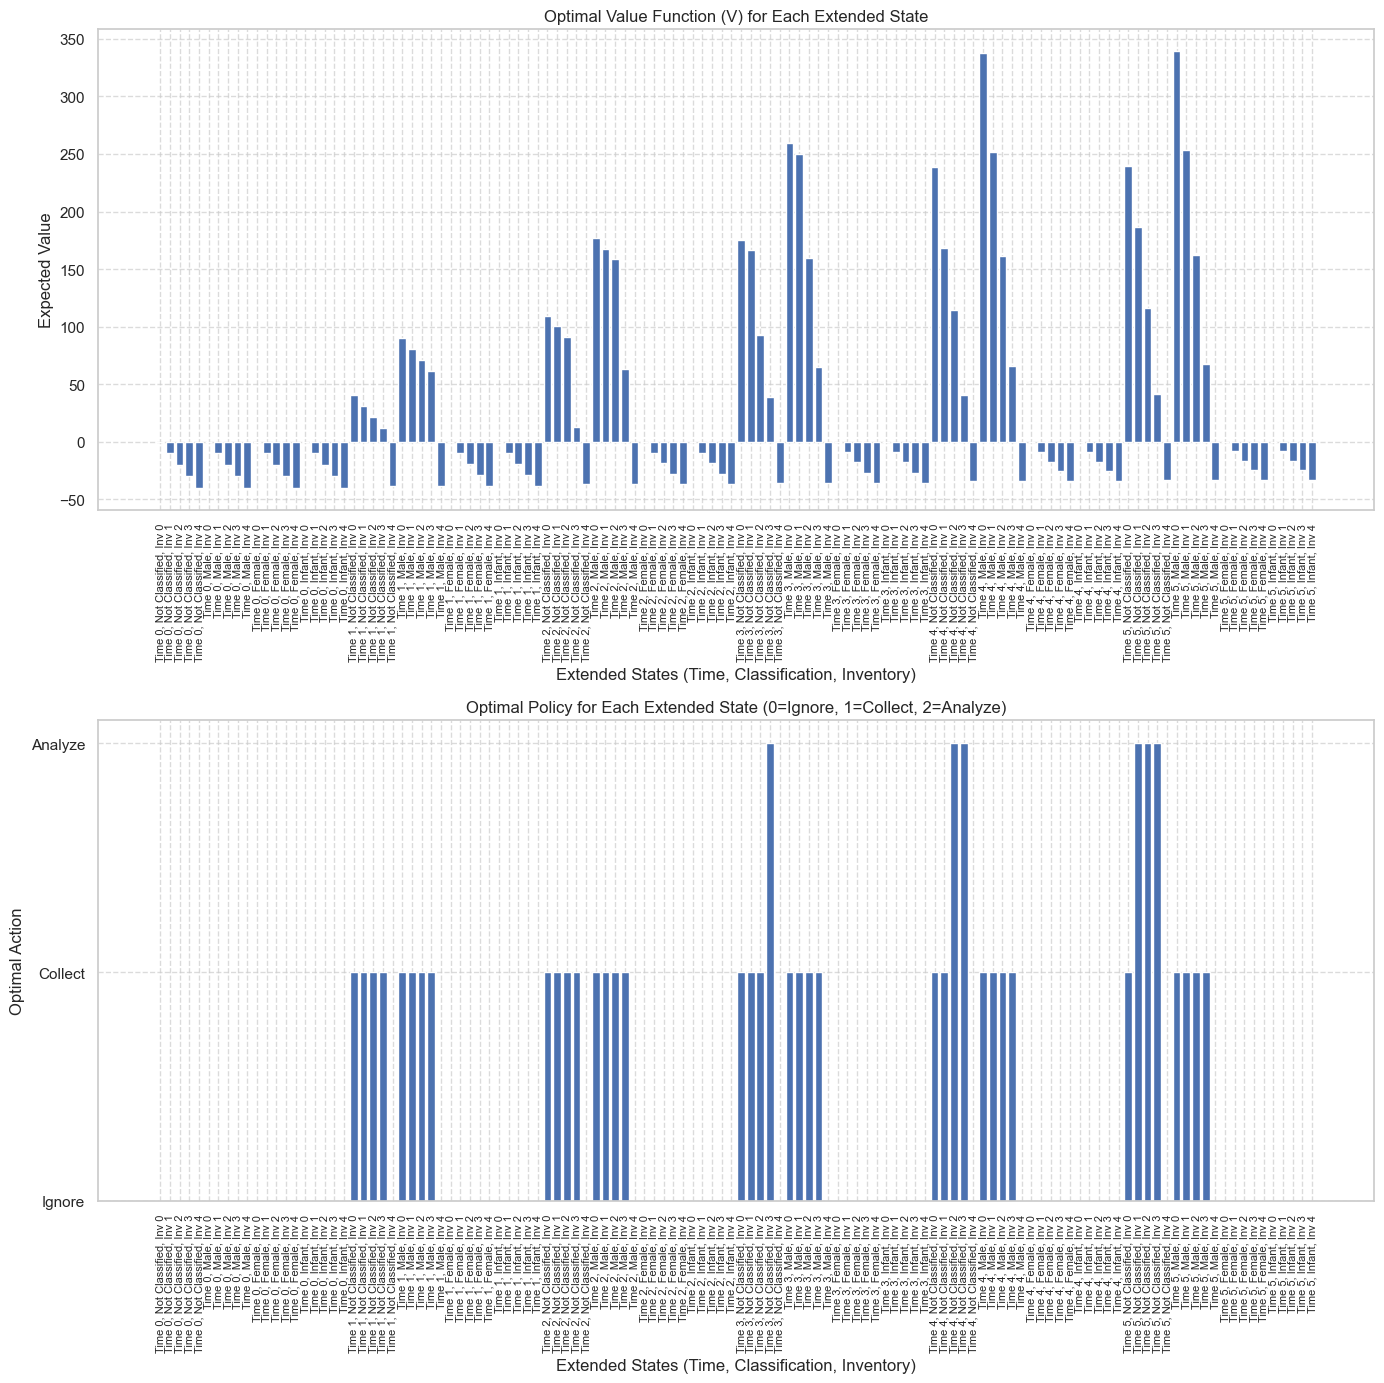

In [165]:
horizon_time = 5

mdp = EnhancedDiverMDP(time_steps=horizon_time, max_inventory=4,
                       prob_male=0.8, prob_female=0.1, prob_infant=0.1,
                       profit_male=100.0, cost_female=-100.0, cost_infant=-150.0,
                       time_cost_analyze=2, time_cost_ignore=1, discount_factor=0.95,
                       holding_cost=0.1, overcapacity_penalty=-0.25, spoilage_penalty=-0.5,
                       cost_analyse=1)

V, policy = mdp.value_iteration()

print("Optimal Value Function (V):")
for i, v in enumerate(V):
    print(f"  State {mdp.get_state_name(i)}: {v:.2f}")

print("\nOptimal Policy:")
for i, p in enumerate(policy):
    action_name = ["Ignore", "Collect", "Analyze"][p]
    print(f"  State {mdp.get_state_name(i)}: {action_name}")

# ------------------- Visualization -------------------
state_labels = [mdp.get_state_label(i) for i in range(len(mdp.states))]
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

# Plot Optimal Value Function
axs[0].bar(range(len(V)), V)
axs[0].set_xticks(range(len(V)))
axs[0].set_xticklabels(state_labels, rotation=90, fontsize=8)
axs[0].set_xlabel("Extended States (Time, Classification, Inventory)")
axs[0].set_ylabel("Expected Value")
axs[0].set_title("Optimal Value Function (V) for Each Extended State")
axs[0].grid(True, linestyle="--", alpha=0.7)

# Plot Optimal Policy
axs[1].bar(range(len(policy)), policy)
axs[1].set_xticks(range(len(policy)))
axs[1].set_xticklabels(state_labels, rotation=90, fontsize=8)
axs[1].set_xlabel("Extended States (Time, Classification, Inventory)")
axs[1].set_ylabel("Optimal Action")
axs[1].set_title("Optimal Policy for Each Extended State (0=Ignore, 1=Collect, 2=Analyze)")
axs[1].set_yticks(range(3))
axs[1].set_yticklabels(["Ignore", "Collect", "Analyze"])
axs[1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [166]:
# Print Value Function and Policy for reference
print("Optimal Value Function (V):")
for i, v in enumerate(V):
    print(f"  State {mdp.get_state_name(i)}: {v:.2f}")

print("\nOptimal Policy:")
for i, p in enumerate(policy):
    action_name = ["Ignore", "Collect", "Analyze"][p]
    print(f"  State {mdp.get_state_name(i)}: {action_name}")

# Choose an initial state. For example, starting at full time (5), not classified (0), empty inventory (0):
initial_state = (horizon_time, 0, 0)
initial_state_idx = mdp.state_index[initial_state]

# Simulate one episode
times, cum_rewards = simulate_episode(mdp, policy, initial_state_idx)

# Plot cumulative reward versus time remaining
plt.figure(figsize=(10, 6))
plt.plot(times, cum_rewards, marker='o')
plt.xlabel("Time Remaining")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward vs Time Remaining")
plt.gca().invert_xaxis()  # Invert x-axis so time decreases from left to right
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

Optimal Value Function (V):
  State (0, 0, 0): 0.00
  State (0, 0, 1): -10.00
  State (0, 0, 2): -20.00
  State (0, 0, 3): -30.00
  State (0, 0, 4): -40.00
  State (0, 1, 0): 0.00
  State (0, 1, 1): -10.00
  State (0, 1, 2): -20.00
  State (0, 1, 3): -30.00
  State (0, 1, 4): -40.00
  State (0, 2, 0): 0.00
  State (0, 2, 1): -10.00
  State (0, 2, 2): -20.00
  State (0, 2, 3): -30.00
  State (0, 2, 4): -40.00
  State (0, 3, 0): 0.00
  State (0, 3, 1): -10.00
  State (0, 3, 2): -20.00
  State (0, 3, 3): -30.00
  State (0, 3, 4): -40.00
  State (1, 0, 0): 40.50
  State (1, 0, 1): 30.90
  State (1, 0, 2): 21.30
  State (1, 0, 3): 11.70
  State (1, 0, 4): -38.40
  State (1, 1, 0): 90.50
  State (1, 1, 1): 80.90
  State (1, 1, 2): 71.30
  State (1, 1, 3): 61.70
  State (1, 1, 4): -38.40
  State (1, 2, 0): 0.00
  State (1, 2, 1): -9.60
  State (1, 2, 2): -19.20
  State (1, 2, 3): -28.80
  State (1, 2, 4): -38.40
  State (1, 3, 0): 0.00
  State (1, 3, 1): -9.60
  State (1, 3, 2): -19.20
  Stat

TypeError: simulate_episode() takes 2 positional arguments but 3 were given

In [144]:
class DiverMDPEnv:
    def __init__(self, mdp):
        """
        mdp: an instance of your MDP (e.g., DiverMDP or EnhancedDiverMDP)
        initial_state: an optional default initial state tuple (e.g., (time_steps, abalone_status, inventory)).
                       If not provided, the reset method will sample uniformly from all states with full time.
        """
        self.mdp = mdp
        self.current_state_idx = None

    def reset(self):
        """
        Reset the environment to a random initial state.
        The initial state is defined as:
          - Time remaining: full time (self.mdp.time_steps)
          - Abalone status: randomly sampled from 0 to self.mdp.num_abalone_status - 1
          - Inventory: 0
        """
        # Sample a random abalone status uniformly.
        abalone_state = np.random.randint(self.mdp.num_abalone_status)
        # Set initial time to the maximum available (full time) and inventory to 0.
        initial_state = (self.mdp.time_steps, abalone_state, 0)
        # Update the current state index using the initial state.
        self.current_state_idx = self.mdp.state_index[initial_state]
        # Return the state (as a tuple) corresponding to the current state index.
        return self.mdp.get_state_name(self.current_state_idx)

    def step(self, action):
        """
        Takes an action and returns:
            next_state: the next state tuple,
            reward: the immediate reward,
            done: True if the episode is over (e.g., time is 0), False otherwise,
            info: any extra info (empty dict in this case)
        """
        current_state = self.mdp.get_state_name(self.current_state_idx)
        time_remaining = current_state[0]

        if time_remaining == 0:
            return current_state, 0, True, {}

        probs = self.mdp.transition_matrix[self.current_state_idx, action, :]
        probs = probs / np.sum(probs)
        total_prob = np.sum(probs)
        if total_prob == 0:
            probs = np.ones(len(probs)) / len(probs)
        else:
            probs = probs / total_prob
        next_state_idx = np.random.choice(range(len(self.mdp.states)), p=probs)
        reward = self.mdp.reward_matrix[self.current_state_idx, action, next_state_idx]
        self.current_state_idx = next_state_idx
        next_state = self.mdp.get_state_name(self.current_state_idx)
        done = next_state[0] == 0

        return next_state, reward, done, {}

    def render(self):
        """Optional: Print the current state."""
        print("Current state:", self.mdp.get_state_name(self.current_state_idx))

# --- Simulation function to sample one full trajectory ---
def simulate_episode(env, policy):
    """
    Simulates one episode following the given policy from the environment.
    Returns:
        times: list of time_remaining values at each step (including terminal state).
        cum_rewards: list of cumulative rewards at each step (including terminal state).
    """
    state = env.reset()
    times = []
    cum_rewards = []
    cumulative_reward = 0
    done = False

    while not done:
        times.append(state[0])
        cum_rewards.append(cumulative_reward)
        current_state_idx = env.mdp.state_index[state]
        action = policy[current_state_idx]
        next_state, reward, done, _ = env.step(action)
        cumulative_reward += reward
        state = next_state
    # Record terminal state info.
    times.append(state[0])
    cum_rewards.append(cumulative_reward)
    return times, cum_rewards

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a Seaborn theme for nice visuals.
sns.set_theme(style="whitegrid")

def simulate_episode_with_details(env, policy):
    """
    Simulates one episode following the given policy from the environment.
    Returns:
        times: list of time_remaining values at each step (including terminal state).
        cum_rewards: list of cumulative rewards at each step.
        state_history: list of states (tuples) at each step.
        action_history: list of actions taken at each step.
    """
    state = env.reset()
    times = []
    cum_rewards = []
    state_history = []
    action_history = []
    cumulative_reward = 0
    done = False

    while not done:
        times.append(state[0])
        cum_rewards.append(cumulative_reward)
        state_history.append(state)
        current_state_idx = env.mdp.state_index[state]
        action = policy[current_state_idx]
        action_history.append(action)
        next_state, reward, done, _ = env.step(action)
        cumulative_reward += reward
        state = next_state

    # Record terminal state info.
    times.append(state[0])
    cum_rewards.append(cumulative_reward)
    state_history.append(state)
    return times, cum_rewards, state_history, action_history

In [145]:
horizon_time = 5

mdp = EnhancedDiverMDP(time_steps=horizon_time, max_inventory=2,
                       prob_male=0.6, prob_female=0.3, prob_infant=0.1,
                       profit_male=100.0, cost_female=-100.0, cost_infant=-150.0,
                       time_cost_analyze=2, time_cost_ignore=1, discount_factor=0.95,
                       holding_cost=0.1, overcapacity_penalty=-0.25, spoilage_penalty=-0.5,
                       cost_analyse=1)

env = DiverMDPEnv(mdp)

In [146]:
V, policy = mdp.value_iteration()

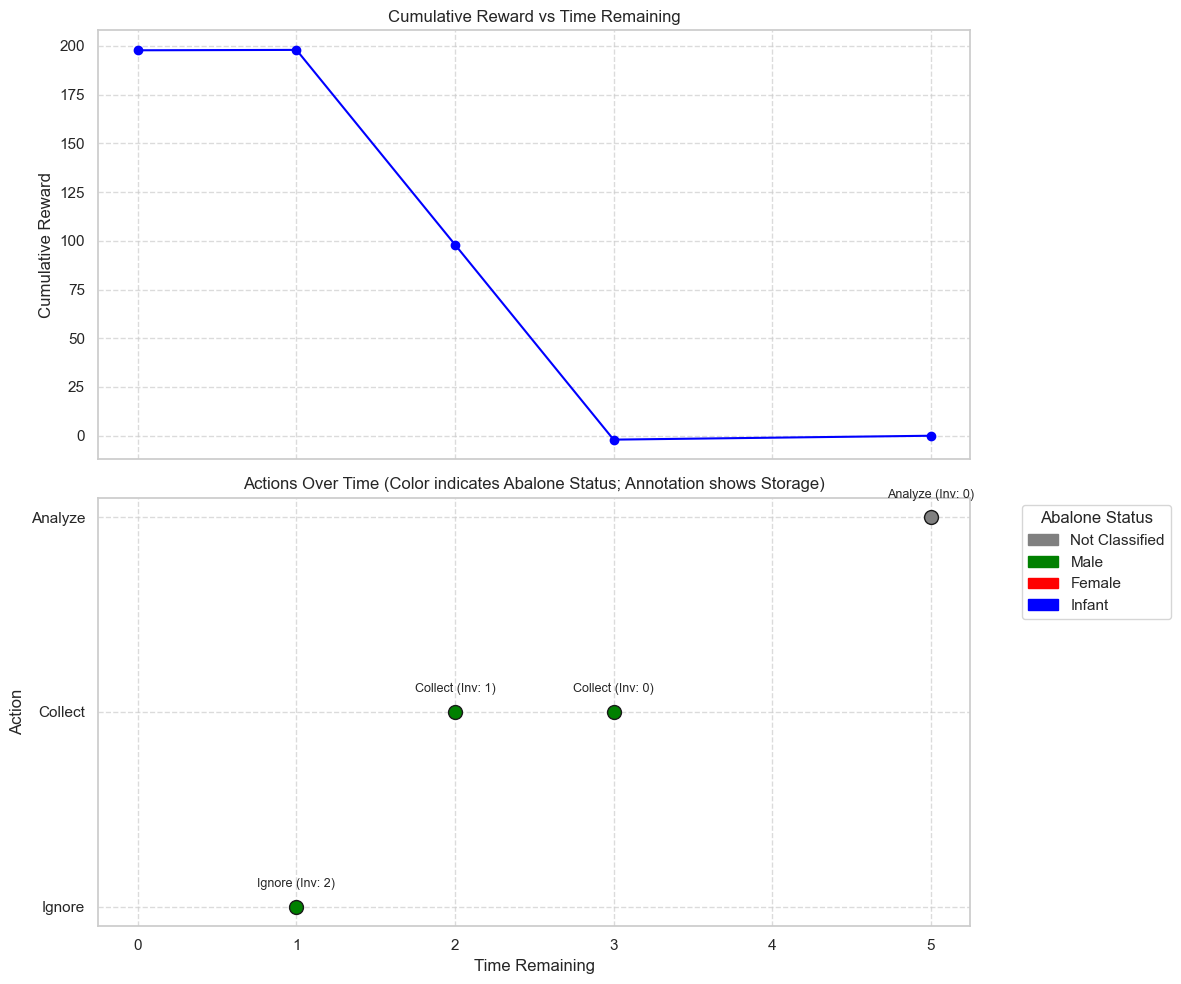

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Set a Seaborn theme for nicer visuals.
sns.set_theme(style="whitegrid")

def simulate_episode_with_details(env, policy):
    """
    Simulates one episode following the given policy from the environment.
    Returns:
        times: list of time_remaining values at each step (including terminal state).
        cum_rewards: list of cumulative rewards at each step.
        state_history: list of states (tuples) at each step.
        action_history: list of actions taken at each step.
    """
    state = env.reset()
    times = []
    cum_rewards = []
    state_history = []
    action_history = []
    cumulative_reward = 0
    done = False

    while not done:
        times.append(state[0])
        cum_rewards.append(cumulative_reward)
        state_history.append(state)
        current_state_idx = env.mdp.state_index[state]
        action = policy[current_state_idx]
        action_history.append(action)
        next_state, reward, done, _ = env.step(action)
        cumulative_reward += reward
        state = next_state

    # Record terminal state info.
    times.append(state[0])
    cum_rewards.append(cumulative_reward)
    state_history.append(state)
    return times, cum_rewards, state_history, action_history

# Assume env and policy have been created from your MDP.
# For example, env is an instance of DiverMDPEnv and policy is the computed optimal policy.
times, cum_rewards, state_history, action_history = simulate_episode_with_details(env, policy)

# For the actions plot, map action numbers to strings.
action_labels = {0: "Ignore", 1: "Collect", 2: "Analyze"}

# Extract abalone status and inventory from each state.
abalone_status = [s[1] for s in state_history]
inventory_levels = [s[2] for s in state_history]

# Define a color palette for abalone status.
# Adjust the palette as needed.
status_palette = {0: 'gray', 1: 'green', 2: 'red', 3:'blue'}

# Create custom legend handles.
legend_handles = [mpatches.Patch(color=status_palette[st], label=label)
                  for st, label in zip([0, 1, 2, 3], ["Not Classified", "Male", "Female", "Infant"])]

# Create a figure with two subplots: one for cumulative reward and one for actions.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top Plot: Cumulative Reward vs Time Remaining
ax1.plot(times, cum_rewards, marker='o', color='blue')
ax1.set_ylabel("Cumulative Reward")
ax1.set_title("Cumulative Reward vs Time Remaining")
ax1.invert_xaxis()  # Time decreases from left to right
ax1.grid(True, linestyle="--", alpha=0.7)

# Bottom Plot: Actions vs Time Remaining
# Use a scatter plot to display actions with marker colors representing abalone status.
for t, action, state in zip(times[:-1], action_history, state_history[:-1]):
    color = status_palette[state[1]]
    ax2.scatter(t, action, color=color, s=100, edgecolor='k')
    # Annotate with action label and current inventory level.
    ax2.text(t, action + 0.1, f"{action_labels[action]} (Inv: {state[2]})", fontsize=9, ha='center')

ax2.set_xlabel("Time Remaining")
ax2.set_ylabel("Action")
ax2.set_title("Actions Over Time (Color indicates Abalone Status; Annotation shows Storage)")
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(["Ignore", "Collect", "Analyze"])
ax2.invert_xaxis()
ax2.grid(True, linestyle="--", alpha=0.7)

# Place legend outside the plot (upper left outside the axes)
ax2.legend(handles=legend_handles, title="Abalone Status", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Optimal Value Function (V):
  State (0, 0, 0): 0.00
  State (0, 0, 1): -10.00
  State (0, 0, 2): -20.00
  State (0, 0, 3): -30.00
  State (0, 0, 4): -40.00
  State (0, 1, 0): 0.00
  State (0, 1, 1): -10.00
  State (0, 1, 2): -20.00
  State (0, 1, 3): -30.00
  State (0, 1, 4): -40.00
  State (0, 2, 0): 0.00
  State (0, 2, 1): -10.00
  State (0, 2, 2): -20.00
  State (0, 2, 3): -30.00
  State (0, 2, 4): -40.00
  State (0, 3, 0): 0.00
  State (0, 3, 1): -10.00
  State (0, 3, 2): -20.00
  State (0, 3, 3): -30.00
  State (0, 3, 4): -40.00
  State (1, 0, 0): 0.00
  State (1, 0, 1): -9.60
  State (1, 0, 2): -19.20
  State (1, 0, 3): -28.80
  State (1, 0, 4): -38.40
  State (1, 1, 0): 90.50
  State (1, 1, 1): 80.90
  State (1, 1, 2): 71.30
  State (1, 1, 3): 61.70
  State (1, 1, 4): -38.40
  State (1, 2, 0): 0.00
  State (1, 2, 1): -9.60
  State (1, 2, 2): -19.20
  State (1, 2, 3): -28.80
  State (1, 2, 4): -38.40
  State (1, 3, 0): 0.00
  State (1, 3, 1): -9.60
  State (1, 3, 2): -19.20
  Sta

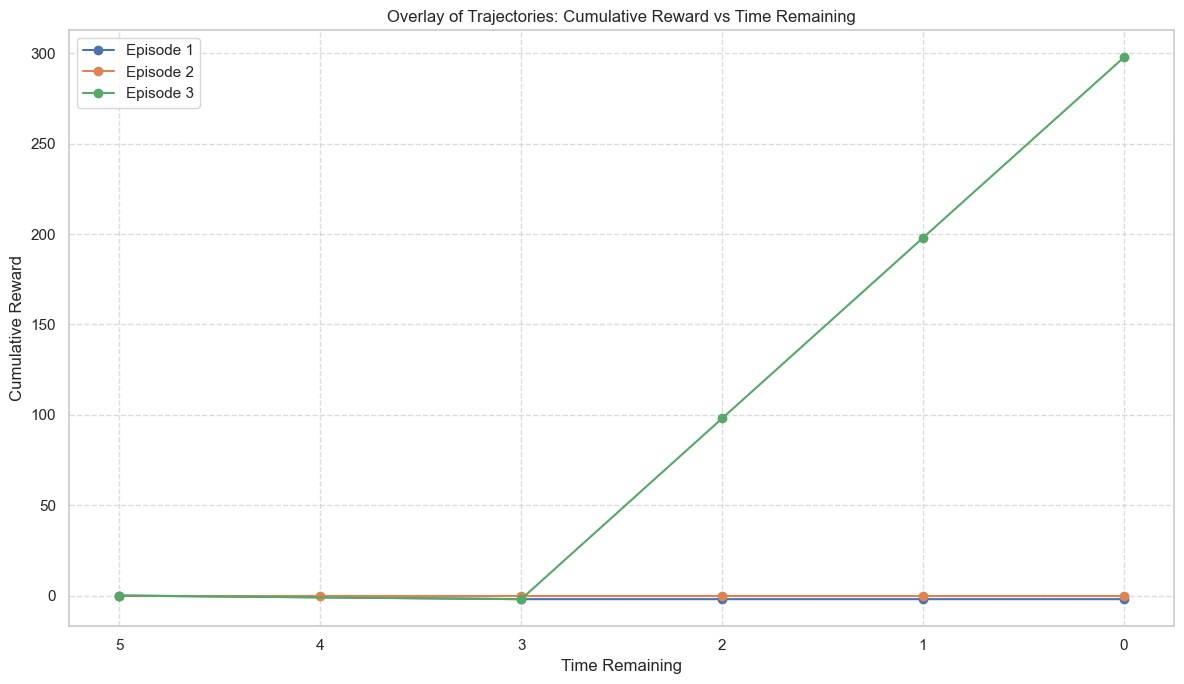

In [24]:


# Print the optimal value function and policy for reference.
print("Optimal Value Function (V):")
for i, v in enumerate(V):
    print(f"  State {mdp.get_state_name(i)}: {v:.2f}")

print("\nOptimal Policy:")
for i, p in enumerate(policy):
    action_name = ["Ignore", "Collect", "Analyze"][p]
    print(f"  State {mdp.get_state_name(i)}: {action_name}")

# Create the environment with an initial state: full time and not classified.


# Sample multiple trajectories.
num_episodes = 3
all_times = []
all_cum_rewards = []

for i in range(num_episodes):
    times, cum_rewards = simulate_episode(env, policy)
    all_times.append(times)
    all_cum_rewards.append(cum_rewards)

# Plot overlay of trajectories.
plt.figure(figsize=(12, 7))
for i in range(num_episodes):
    plt.plot(all_times[i], all_cum_rewards[i], marker='o', label=f"Episode {i+1}")
plt.xlabel("Time Remaining")
plt.ylabel("Cumulative Reward")
plt.title("Overlay of Trajectories: Cumulative Reward vs Time Remaining")
plt.gca().invert_xaxis()  # So time decreases left to right.
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

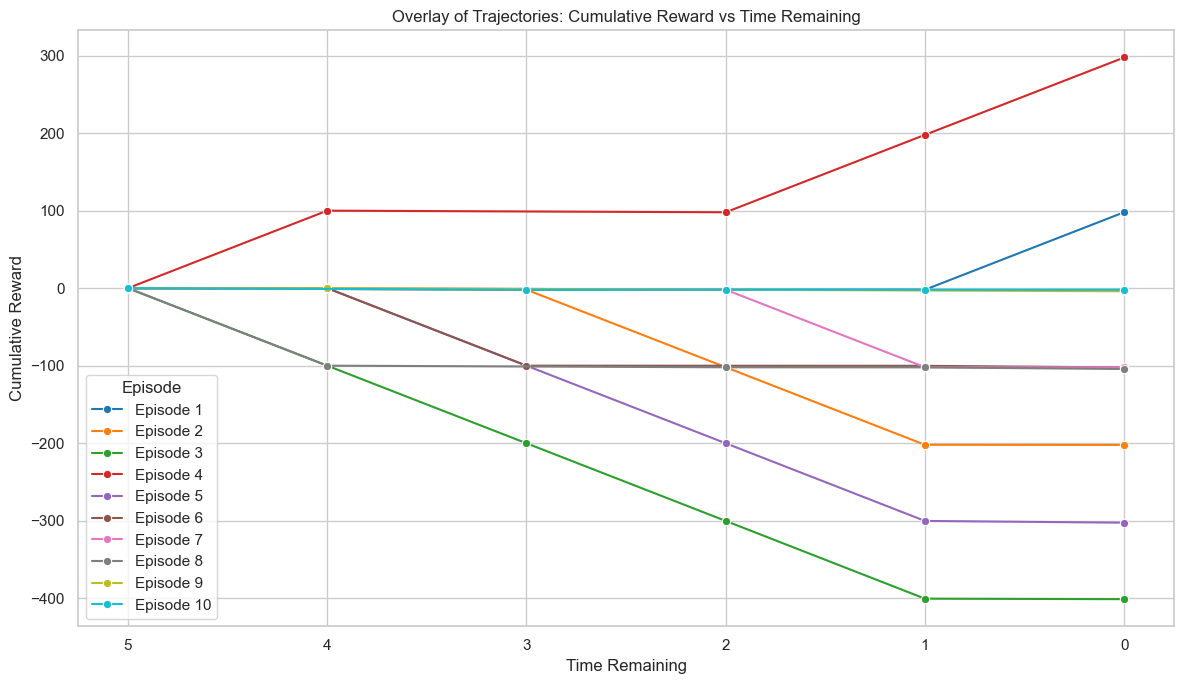

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a Seaborn theme for nicer plots.
sns.set_theme(style="whitegrid")

# --- Assume the DiverMDPEnv class and simulate_episode_callable function are defined as in the previous snippet.
# For example, here we use simulate_episode_callable to sample trajectories using a random policy.
random_policy = lambda s: np.random.randint(mdp.num_actions)

def simulate_episode_callable(env, policy_func):
    state = env.reset()
    times = []
    cum_rewards = []
    cumulative_reward = 0
    done = False
    while not done:
        times.append(state[0])
        cum_rewards.append(cumulative_reward)
        action = policy_func(state)
        next_state, reward, done, _ = env.step(action)
        cumulative_reward += reward
        state = next_state
    # Record terminal state info.
    times.append(state[0])
    cum_rewards.append(cumulative_reward)
    return times, cum_rewards

# Sample multiple trajectories using the random policy.
num_episodes = 10
all_times = []
all_cum_rewards = []

for i in range(num_episodes):
    times, cum_rewards = simulate_episode_callable(env, random_policy)
    all_times.append(times)
    all_cum_rewards.append(cum_rewards)

# Convert the trajectories into a DataFrame for Seaborn.
# We assume that each trajectory has the same length. If not, you may need to pad shorter ones.
data = []
for ep in range(num_episodes):
    for t, r in zip(all_times[ep], all_cum_rewards[ep]):
        data.append({"Episode": f"Episode {ep+1}", "Time Remaining": t, "Cumulative Reward": r})

df = pd.DataFrame(data)

# Create a line plot with markers using Seaborn.
plt.figure(figsize=(12, 7))
sns.lineplot(data=df, x="Time Remaining", y="Cumulative Reward", hue="Episode", marker="o", palette="tab10")
plt.title("Overlay of Trajectories: Cumulative Reward vs Time Remaining")
plt.gca().invert_xaxis()  # Invert x-axis so that time decreases from left to right.
plt.xlabel("Time Remaining")
plt.ylabel("Cumulative Reward")
plt.tight_layout()
plt.show()

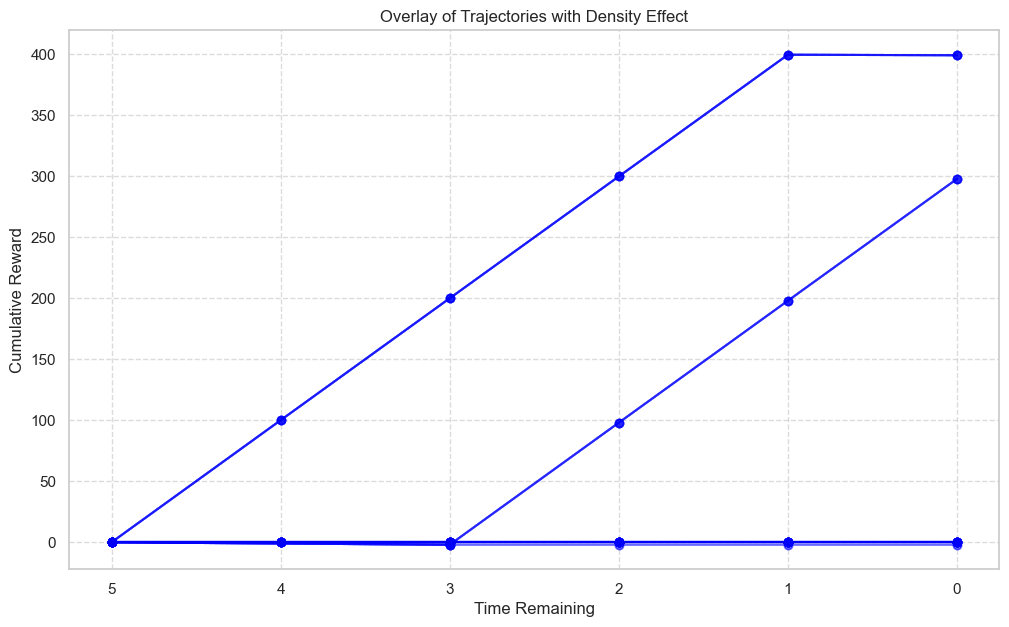

In [26]:
# Simulate many episodes and overlay them with transparency
num_episodes = 100
all_times = []
all_cum_rewards = []

for i in range(num_episodes):
    times, cum_rewards = simulate_episode(env, policy)
    all_times.append(times)
    all_cum_rewards.append(cum_rewards)

plt.figure(figsize=(12, 7))
for i in range(num_episodes):
    plt.plot(all_times[i], all_cum_rewards[i], marker='o', alpha=0.1, color='blue')
plt.xlabel("Time Remaining")
plt.ylabel("Cumulative Reward")
plt.title("Overlay of Trajectories with Density Effect")
plt.gca().invert_xaxis()  # So time decreases left to right.
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()